#  import stuff

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
import random
from tqdm import tqdm
import featuretools as ft
from joblib import dump, load
from imblearn.combine import SMOTETomek

from sklearn.preprocessing import MinMaxScaler, minmax_scale, scale, power_transform, quantile_transform, normalize 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import make_scorer, log_loss
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.multioutput import MultiOutputClassifier
from  sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline,Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.calibration import CalibratedClassifierCV

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

from tensorflow.keras import layers,models,metrics,callbacks,losses
from tensorflow.keras.activations import relu,sigmoid,swish,tanh,selu
from tensorflow.keras.optimizers import SGD,Adam,RMSprop,Adadelta,Nadam
from tensorflow.keras.models import Model, Sequential,load_model
import tensorflow as tf

RANDOM_SEED = 777
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
    
import warnings
warnings.filterwarnings(
    action='ignore',
)

C:\Users\kurma\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
metadata = pd.read_csv('data/metadata.csv')
sup_metadata = pd.read_csv('data/supplemental_metadata.csv')
train_labels = pd.read_csv('data/train_labels.csv', index_col="sample_id")
val_labels = pd.read_csv('data/val_labels.csv',index_col='sample_id')
targets = pd.read_csv('targets.csv',index_col='sample_id')
submission_format = pd.read_csv('data/submission_format.csv')

# Load data

In [4]:
test_df = pd.read_csv('data/test_df.csv',index_col=0,header=[0,1])
train_df = pd.read_csv('data/train_df.csv',index_col=0,header=[0,1])
val_df = pd.read_csv('data/val_df.csv',index_col=0,header=[0,1])

val_df.index = metadata[metadata.split == 'val'].sample_id

val_df.sort_index(inplace=True,axis=1)
test_df.sort_index(inplace=True,axis=1)
train_df.sort_index(inplace=True,axis=1)

In [5]:
%%time
train_df_5 = pd.read_csv('train/train_df_5.csv',index_col=0,header=[0,1])
val_df_5 = pd.read_csv('train/val_df_5.csv',index_col=0,header=[0,1])
test_df_5 = pd.read_csv('test/test_df_5.csv',index_col=0,header=[0,1])

test_df_5.sort_index(inplace=True,axis=1)
val_df_5.sort_index(inplace=True,axis=1)
train_df_5.sort_index(inplace=True,axis=1)

Wall time: 57.4 s


In [6]:
%%time
train_set_50 = pd.read_csv('train/train_val_50.csv',index_col=0,header=[0,1])
test_df_50 = pd.read_csv('test/test_df_50.csv',index_col=0,header=[0,1])
val_df_50 = train_set_50[:val_df.shape[0]]

test_df_50.sort_index(inplace=True,axis=1)
train_set_50.sort_index(inplace=True,axis=1)

Wall time: 1.76 s


In [7]:
train_df_200 = pd.read_csv('train/train_df_200.csv',index_col=0,header=[0,1])
val_df_200 = pd.read_csv('train/val_df_200.csv',index_col=0,header=[0,1])
test_df_200 = pd.read_csv('test/test_df_200.csv',index_col=0,header=[0,1])

test_df_200.sort_index(inplace=True,axis=1)
val_df_200.sort_index(inplace=True,axis=1)
train_df_200.sort_index(inplace=True,axis=1)

In [8]:
train_df_500 = pd.read_csv('train/train_df_500.csv',index_col=0,header=[0,1])
val_df_500 = pd.read_csv('train/val_df_500.csv',index_col=0,header=[0,1])
test_df_500 = pd.read_csv('test/test_df_500.csv',index_col=0,header=[0,1])

test_df_500.sort_index(inplace=True,axis=1)
val_df_500.sort_index(inplace=True,axis=1)
train_df_500.sort_index(inplace=True,axis=1)

In [9]:
train_df_500.shape,train_df_200.shape, train_df.shape, train_set_50.shape, train_df_5.shape

((766, 400), (766, 1000), (766, 1600), (1059, 4200), (766, 42000))

In [10]:
train_set_5 = pd.concat([train_df_5,val_df_5],axis=0)
# train_set_50 = pd.concat([train_set_50,val_df_50],axis=0)
train_set_100 = pd.concat([train_df,val_df],axis=0)
train_set_200 = pd.concat([train_df_200,val_df_200],axis=0)
train_set_500 = pd.concat([train_df_500,val_df_500],axis=0)

In [11]:
test_set_5 = pd.concat([val_df_5,test_df_5],axis=0)
test_set_50 = pd.concat([val_df_50,test_df_50],axis=0)
test_set_100 = pd.concat([val_df,test_df],axis=0)
test_set_200 = pd.concat([val_df_200,test_df_200],axis=0)
test_set_500 = pd.concat([val_df_500,test_df_500],axis=0)

# Binning

In [8]:
sam_id = metadata[metadata.instrument_type == 'sam_testbed'].index
sam_id

Int64Index([ 754,  755,  756,  757,  758,  759,  760,  761,  762,  763,  764,
             765, 1506, 1507, 1508, 1509, 1510, 1511, 1512, 1513, 1514, 1515,
            1516, 1517, 1518, 1519, 1520, 1521, 1522, 1523, 1524, 1525, 1526,
            1527, 1528, 1529, 1530, 1531, 1532, 1533, 1534, 1535, 1536, 1537,
            1538, 1539, 1540, 1541, 1542, 1543, 1544, 1545, 1546, 1547, 1548,
            1549, 1550, 1551, 1552, 1553, 1554, 1555, 1556, 1557, 1558, 1559,
            1560, 1561, 1562, 1563, 1564, 1565, 1566, 1567, 1568, 1569],
           dtype='int64')

In [5]:
train_files = metadata[metadata["split"] == "train"]["features_path"].to_dict()
val_files = metadata[metadata["split"] == "val"]["features_path"].to_dict()
test_files = metadata[metadata["split"] == "test"]["features_path"].to_dict()

print("Number of training samples: ", len(train_files))
print("Number of validation samples: ", len(val_files))
print("Number of testing samples: ", len(test_files))

Number of training samples:  766
Number of validation samples:  293
Number of testing samples:  511


In [80]:
def drop_frac_and_He(df):
    """
    Drops fractional m/z values, m/z values > 100, and carrier gas m/z

    Args:
        df: a dataframe representing a single sample, containing m/z values

    Returns:
        The dataframe without fractional an carrier gas m/z
    """

    # drop fractional m/z values
    df = df[df["m/z"].transform(round) == df["m/z"]]
    assert df["m/z"].apply(float.is_integer).all(), "not all m/z are integers"

    # drop m/z values greater than 99
    df = df[df["m/z"] < 100]

    # drop carrier gas
    df = df[df["m/z"] != 4]
    
    return df

def remove_background_abundance(df):
    """
    Subtracts minimum abundance value

    Args:
        df: dataframe with 'm/z' and 'abundance' columns

    Returns:
        dataframe with minimum abundance subtracted for all observations
    """

    df["abundance_minsub"] = df.groupby(["m/z"])["abundance"].transform(
        lambda x: (x - x.min())
    )

    return df
    
def scale_abun(df):
    """
    Scale abundance from 0-100 according to the min and max values across entire sample

    Args:
        df: dataframe containing abundances and m/z

    Returns:
        dataframe with additional column of scaled abundances
    """
    # v1 =  naive qt transformation (uniform distribution)
    # v2 =  min-max scaling + qt transformation
    # v3 = qt transformation based on groupby mz
    
    print('original')
    sns.kdeplot(df["abundance_minsub"])
    plt.show()

    # df["abun_minsub_scaled"] = quantile_transform(df["abundance_minsub"].astype(float).values.reshape(-1,1),output_distribution='uniform',random_state=RANDOM_SEED)
    print('minmax')
    df["abun_minsub_scaled"] = minmax_scale(df["abundance_minsub"].astype(float))
    for i in range(100):
        try:
            
            df['abun_minsub_scaled'] = quantile_transform(
                temp.groupby('m/z')['abundance'].get_group(i).values.reshape(-1,1),
                output_distribution='uniform',
                random_state=RANDOM_SEED
                )
        except:
            print(f'no mz --> {i}')
            pass
    
    return df

In [75]:
def load_sample(n):
    if n < len(train_files):
        idx = metadata.loc[n,'sample_id']
        print(idx)
        df = pd.read_csv('data/train_features/'+idx+'.csv')
    else:
        idx = metadata.loc[n,'sample_id']
        print(idx)
        df = pd.read_csv('data/test_features/'+idx+'.csv')
    return df

In [77]:
temp = load_sample(760)
temp

S0760


,time,temp,m/z,abundance
0,0.00,0.000,78.0,647.1
1,0.02,0.000,79.0,235.3
2,0.04,0.000,80.0,294.1
3,0.06,0.000,81.0,470.6
4,0.26,0.000,82.0,176.5
...,...,...,...,...
89786,2494.24,1100.556,165.0,0.0
89787,2494.26,1100.544,166.0,0.0
89788,2494.28,1100.532,167.0,0.0
89789,2494.30,1100.520,168.0,0.0


S0000
S0001
S0002
S0003
S0004
S0005
S0006
S0007
S0008
S0009
S0010
S0011
S0012
S0013
S0014
S0015
S0016
S0017
S0018
S0019
S0020
S0021
S0022
S0023
S0024
S0025
S0026
S0027
S0028
S0029
S0030
S0031
S0032
S0033
S0034
S0035
S0036
S0037
S0038
S0039


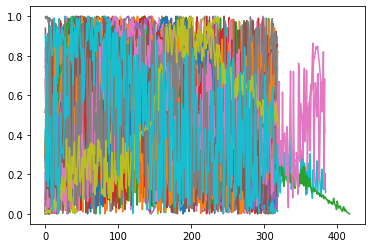

In [79]:
for i in range(40):
    temp = load_sample(i)
    plt.plot(quantile_transform(temp.groupby('m/z')['abundance'].get_group(i).values.reshape(-1,1),output_distribution='uniform',random_state=RANDOM_SEED))

In [35]:
# Preprocess function
def preprocess_sample(df):
    df = drop_frac_and_He(df)
    df = remove_background_abundance(df)
    df = scale_abun(df)
    return df

In [50]:
# Create a series of temperature bins
temprange = pd.interval_range(start=-100, end=2000, freq=100)
temprange

# Make dataframe with rows that are combinations of all temperature bins
# and all m/z values
allcombs = list(itertools.product(temprange, [*range(0, 100)]))

allcombs_df = pd.DataFrame(allcombs, columns=["temp_bin", "m/z"])
print(allcombs_df.shape)
allcombs_df.head()

(2100, 2)


,temp_bin,m/z
0,"(-100, 0]",0
1,"(-100, 0]",1
2,"(-100, 0]",2
3,"(-100, 0]",3
4,"(-100, 0]",4


In [49]:
def abun_per_tempbin(df):

    """
    Transforms dataset to take the preprocessed max abundance for each
    temperature range for each m/z value

    Args:
        df: dataframe to transform

    Returns:
        transformed dataframe
    """
    
    # Bin temperatures
    df["temp_bin"] = pd.cut(df["temp"], bins=temprange)

    # Combine with a list of all temp bin-m/z value combinations
    df = pd.merge(allcombs_df, df, on=["temp_bin", "m/z"], how="left")

    # Aggregate to temperature bin level to find max
    df = df.groupby(["temp_bin", "m/z"]).max("abun_minsub_scaled").reset_index()

    # Fill in 0 for abundance values without information
    df = df.replace(np.nan, 0)

    # Reshape so each row is a single sample
    df = df.pivot_table(columns=["m/z", "temp_bin"], values=["abun_minsub_scaled"])

    return df

In [38]:
def sam_2_com(df):
    df['abundance'] = df['abundance']*1.60217646 * 10**-19
    df['time'] = minmax_scale(df['time'],feature_range=(0,1800))
    df['temp'] = minmax_scale(df['temp'],feature_range=(0,1200))
    return df

  0%|          | 0/766 [00:00<?, ?it/s]

Total number of train files:  766
original


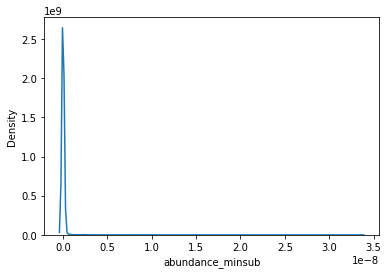

minmax


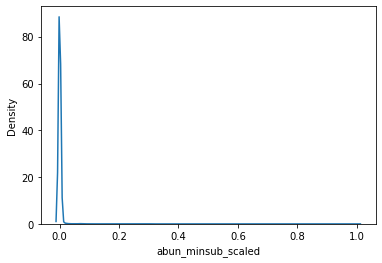

qt


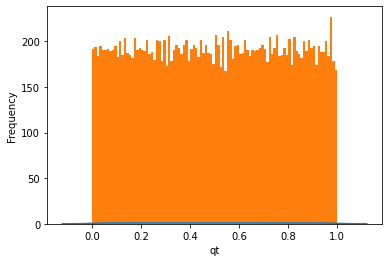

qt


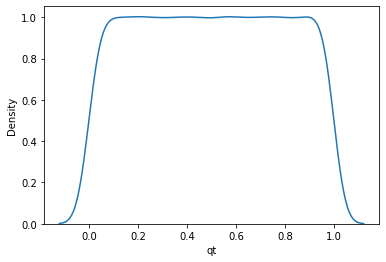

  0%|          | 0/766 [00:01<?, ?it/s]


In [81]:
# Assembling preprocessed and transformed training set

train_features_dict = {}
print("Total number of train files: ", len(train_files))

for i, (sample_id, filepath) in enumerate(tqdm(train_files.items())):

    # Load training sample
    temp = pd.read_csv('data/' + filepath)

    # map sam samples to com samples
    if sample_id in sam_id:
        temp = sam_2_com(temp)
    
    # Preprocessing training sample
    train_sample_pp = preprocess_sample(temp)

    # Feature engineering
    train_sample_fe = abun_per_tempbin(train_sample_pp).reset_index(drop=True)
    train_features_dict[sample_id] = train_sample_fe
    break

train_features = pd.concat(
    train_features_dict, names=["sample_id", "dummy_index"]
).reset_index(level="dummy_index", drop=True)

In [ ]:
# Assembling preprocessed and transformed valing set

val_features_dict = {}
print("Total number of val files: ", len(val_files))

for i, (sample_id, filepath) in enumerate(tqdm(val_files.items())):

    # Load valing sample
    temp = pd.read_csv('data/' + filepath)

    # Preprocessing valing sample
    val_sample_pp = preprocess_sample(temp)

    # Feature engineering
    val_sample_fe = abun_per_tempbin(val_sample_pp).reset_index(drop=True)
    val_features_dict[sample_id] = val_sample_fe

val_features = pd.concat(
    val_features_dict, names=["sample_id", "dummy_index"]
).reset_index(level="dummy_index", drop=True)

In [ ]:
# Assembling preprocessed and transformed testing set

test_features_dict = {}
print("Total number of test files: ", len(test_files))

for i, (sample_id, filepath) in enumerate(tqdm(test_files.items())):

    # Load testing sample
    temp = pd.read_csv('data/' + filepath)

    # map sam samples to com samples
    if sample_id in sam_id:
        temp = sam_2_com(temp)

    # Preprocessing testing sample
    test_sample_pp = preprocess_sample(temp)

    # Feature engineering
    test_sample_fe = abun_per_tempbin(test_sample_pp).reset_index(drop=True)
    test_features_dict[sample_id] = test_sample_fe

test_features = pd.concat(
    test_features_dict, names=["sample_id", "dummy_index"]
).reset_index(level="dummy_index", drop=True)

# total abundance
- this varies coz of min max scaling...

- get mz is here.....

In [15]:
def get_mz(mz,df):
    ''' returns list of columns for given mz'''
    cols_list = []
    for col in df.columns:
        if col[0] == str(mz):
            cols_list.append(col)
    return cols_list

In [19]:
def get_total_abundance(df):
    ''' returns total abundance for each sample'''
    tot_abund_df = pd.DataFrame(index=df.index)
    tot_abund_df['tot_abund'] = df.sum(axis=1)
    for mz in tqdm(range(0,100)):
        tot_abund_df[f"tot_abund_{mz}"] = df[get_mz(mz,df)].sum(axis=1)
    
    print('tot_abund_df.shape',tot_abund_df.shape)
    return tot_abund_df

In [20]:
tot_abund_200 = get_total_abundance(train_set_200)
tot_abund_50 = get_total_abundance(train_set_50)
tot_abund_5 = get_total_abundance(train_set_5)
tot_abund_100 = get_total_abundance(train_set_100)
tot_abund_500 = get_total_abundance(train_set_500)

 25%|██▌       | 25/100 [00:00<00:00, 245.76it/s]

tot_abund_df.shape (1059, 101)


  0%|          | 0/100 [00:00<?, ?it/s]

tot_abund_df.shape (1059, 101)


 32%|███▏      | 32/100 [00:00<00:00, 318.50it/s]

tot_abund_df.shape (1059, 101)


 83%|████████▎ | 83/100 [00:00<00:00, 416.76it/s]

tot_abund_df.shape (1059, 101)


100%|██████████| 100/100 [00:00<00:00, 361.74it/s]

tot_abund_df.shape (1059, 101)


In [21]:
tot_abund_5_test = get_total_abundance(test_set_5)
tot_abund_50_test = get_total_abundance(test_set_50)
tot_abund_100_test = get_total_abundance(test_set_100)
tot_abund_200_test = get_total_abundance(test_set_200)
tot_abund_500_test = get_total_abundance(test_set_500)

 27%|██▋       | 27/100 [00:00<00:00, 265.47it/s]

tot_abund_df.shape (804, 101)


 34%|███▍      | 34/100 [00:00<00:00, 337.65it/s]

tot_abund_df.shape (804, 101)


 35%|███▌      | 35/100 [00:00<00:00, 343.05it/s]

tot_abund_df.shape (804, 101)


 83%|████████▎ | 83/100 [00:00<00:00, 411.32it/s]

tot_abund_df.shape (804, 101)


100%|██████████| 100/100 [00:00<00:00, 366.21it/s]

tot_abund_df.shape (804, 101)


In [25]:
# def get_tempbins(mz):
#     col_list = []
#     for col in train_df.columns:
#         if col[0] == str(mz):
#             col_list.append(col)
#     return col_list

In [26]:
# drop if all values are zero
def check_col(df):
    col_with_zeros = []
    for id,col in enumerate(tqdm(df.columns)):
        if df[col].nunique() == 1:
            col_with_zeros.append(id)
    return col_with_zeros

# get gradients

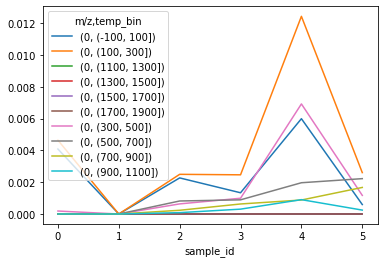

In [19]:
train_set_200.loc[:5,get_mz(0,train_set_200)].plot();

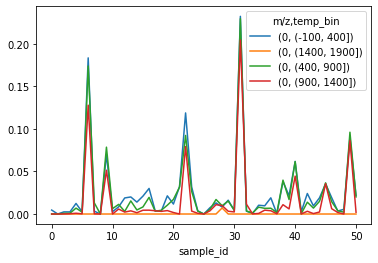

In [20]:
train_set_500.loc[:50,get_mz(0,train_set_500)].plot();

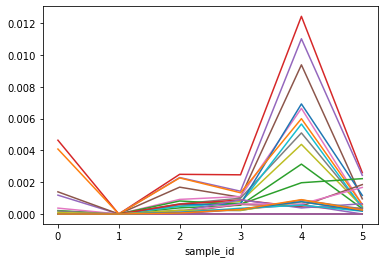

In [21]:
train_set_50.loc[:5,get_mz(0,train_set_50)].plot(legend=False);

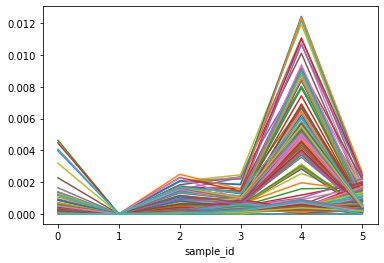

In [22]:
train_set_5.loc[:5,get_mz(0,train_set_5)].plot(legend=False);

In [22]:
def get_grads(df,bin_size=5):
    ''' returns gradients for each mz'''
    grad_df = pd.DataFrame(index=df.index)
    for mz in tqdm(range(0,100)):
        df_mz = df.loc[:,get_mz(mz,df)]
        # df_mz_col1 = df_mz.iloc[:,0].values
        df_mz = df_mz.diff(axis=1)
        # df_mz.iloc[:,0] = df_mz_col1
        df_mz.dropna(axis='columns',inplace=True)
        # df_mz = df_mz/bin_size
        df_mz.columns = [col[0]+ '_' + col[1] + '_' + 'grad' for col in df_mz.columns]
        grad_df = pd.concat([grad_df,df_mz],axis=1)

    print('grad_df.shape',grad_df.shape)

    return  grad_df

In [23]:
%%time
grad_200 = get_grads(train_set_200,200)
grad_50 = get_grads(train_set_50,50)
grad_5 = get_grads(train_set_5,5)
grad_500 = get_grads(train_set_500,500)
grad_100 = get_grads(train_set_100,100)

 10%|█         | 10/100 [00:00<00:00, 96.52it/s]

grad_df.shape (1059, 900)


  3%|▎         | 3/100 [00:00<00:03, 28.65it/s]

grad_df.shape (1059, 4100)


 42%|████▏     | 42/100 [00:00<00:00, 207.38it/s]

grad_df.shape (1059, 41900)


 18%|█▊        | 18/100 [00:00<00:00, 175.23it/s]

grad_df.shape (1059, 300)


100%|██████████| 100/100 [00:00<00:00, 139.33it/s]

grad_df.shape (1059, 1500)
Wall time: 13.7 s


In [24]:
%%time
grad_200_test = get_grads(test_set_200,200)
grad_50_test = get_grads(test_set_50,50)
grad_5_test = get_grads(test_set_5,5)
grad_500_test = get_grads(test_set_500,500)
grad_100_test = get_grads(test_set_100,100)

 15%|█▌        | 15/100 [00:00<00:00, 142.26it/s]

grad_df.shape (804, 900)


  4%|▍         | 4/100 [00:00<00:02, 38.94it/s]

grad_df.shape (804, 4100)


 39%|███▉      | 39/100 [00:00<00:00, 192.84it/s]

grad_df.shape (804, 41900)


 13%|█▎        | 13/100 [00:00<00:00, 128.88it/s]

grad_df.shape (804, 300)


100%|██████████| 100/100 [00:00<00:00, 103.72it/s]

grad_df.shape (804, 1500)
Wall time: 11.6 s


# add metadata
- mean,varience of all mzs
- mean,varience of a tempbin 

In [25]:
def get_mean_std(df):
    ''' returns mean and std for each mz'''
    mean_std_df = pd.DataFrame(index=df.index)
    for mz in tqdm(range(0,100)):
        df_mz = df.loc[:,get_mz(mz,df)]
        df_mz[f'{mz}_mean'] = df_mz.mean(axis=1)
        df_mz[f'{mz}_std'] = df_mz.std(axis=1)
        mean_std_df = pd.concat([mean_std_df,df_mz],axis=1)
    print('mean_std_df.shape',mean_std_df.shape)
    return mean_std_df

In [26]:
mean_std_5 = get_mean_std(train_set_5)
mean_std_50 = get_mean_std(train_set_50)
mean_std_100 = get_mean_std(train_set_100)
mean_std_200 = get_mean_std(train_set_200)
mean_std_500 = get_mean_std(train_set_500)

  9%|▉         | 9/100 [00:00<00:01, 84.76it/s]

mean_std_df.shape (1059, 42200)


 15%|█▌        | 15/100 [00:00<00:00, 138.61it/s]

mean_std_df.shape (1059, 4400)


 18%|█▊        | 18/100 [00:00<00:00, 171.14it/s]

mean_std_df.shape (1059, 1800)


 16%|█▌        | 16/100 [00:00<00:00, 154.31it/s]

mean_std_df.shape (1059, 1200)


100%|██████████| 100/100 [00:00<00:00, 139.36it/s]

mean_std_df.shape (1059, 600)


In [27]:
mean_std_5_test = get_mean_std(test_set_5)
mean_std_50_test = get_mean_std(test_set_50)
mean_std_100_test = get_mean_std(test_set_100)
mean_std_200_test = get_mean_std(test_set_200)
mean_std_500_test = get_mean_std(test_set_500)

 28%|██▊       | 28/100 [00:00<00:00, 133.59it/s]

mean_std_df.shape (804, 42200)


 26%|██▌       | 26/100 [00:00<00:00, 125.07it/s]

mean_std_df.shape (804, 4400)


 21%|██        | 21/100 [00:00<00:00, 202.68it/s]

mean_std_df.shape (804, 1800)


 23%|██▎       | 23/100 [00:00<00:00, 113.65it/s]

mean_std_df.shape (804, 1200)


100%|██████████| 100/100 [00:00<00:00, 117.71it/s]

mean_std_df.shape (804, 600)


**next up**
- quantile transform, guassian rank transform , feature tools and nns

# cv

In [28]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)
log_loss_scorer = make_scorer(log_loss, needs_proba=True)
phy = 'phyllosilicate'

In [29]:
logreg_clf = LogisticRegression(penalty='l1',C=1, solver='liblinear',random_state=RANDOM_SEED)
logreg_clf

LogisticRegression(C=1, penalty='l1', random_state=777, solver='liblinear')

In [39]:
def get_imp_coefs(clf,df,target_col):
    """
    Returns the df with imp cols based on logreg coefs...
    """
    clf.fit(df,targets[target_col])
    coefs = clf.coef_
    coefs = pd.Series(coefs.ravel())
    coefs = coefs.where(coefs != 0.0).dropna().sort_values(ascending=False).index
    # imp_fts_5[target_col] = coefs
    
    cv_score = cross_val_score(clf,df,targets[target_col],cv=skf,scoring=log_loss_scorer)
    print(cv_score,cv_score.mean())
    # print(target_col)
    # print(coefs)
    # print("------------------------------------")
    
    return df.iloc[:,coefs],coefs

In [40]:
# X_500 = pd.concat([train_set_500,grad_500,tot_abund_500,mean_std_500],axis=1)
# X_200 = pd.concat([train_set_200,grad_200,tot_abund_200,mean_std_200],axis=1)
# X_50 = pd.concat([train_set_50,grad_50,tot_abund_50,mean_std_50],axis=1)
# X_5 = pd.concat([train_set_5,grad_5,tot_abund_5,mean_std_5],axis=1)
# X_5.shape

In [41]:
def get_imp_coefs_for_tar(clf,df_set,tar):
    imp_fts = dict()
    
    imp_df_org,imp_fts['org_set'] = get_imp_coefs(clf,df_set[0],tar)
    imp_df_tot_abund,imp_fts['tot_abund_set'] = get_imp_coefs(clf,df_set[1],tar)
    imp_df_grad,imp_fts['grad_set'] = get_imp_coefs(clf,df_set[2],tar)
    imp_df_mean_std,imp_fts['mean_std_set'] = get_imp_coefs(clf,df_set[3],tar)
    
    print(imp_df_org.shape,imp_df_tot_abund.shape,imp_df_grad.shape,imp_df_mean_std.shape)
    imp_df = pd.concat([imp_df_org,imp_df_tot_abund,imp_df_grad,imp_df_mean_std],axis=1)
    print(imp_df.shape)

    return imp_df,imp_fts

## trail

In [33]:
imp_df = get_imp_coefs(logreg_clf,X_200,phy)
imp_df.shape

NameError: name 'X_200' is not defined

In [64]:
imp_df = get_imp_coefs(logreg_clf,train_set_50,phy)
imp_df.shape

[0.39902645 0.4469758  0.54718085 0.43083517 0.39331084] 0.44346581996003975
phyllosilicate
Int64Index([1120,  884,  458,  450, 1119,  455, 1122,  451, 1133, 1132,  423,
            1096,  445,  448,  459,  456, 1665,  518, 1117, 1118, 1672,  919,
            1121,  920, 1123, 1126,  428, 1125,  422,  449, 1668,   76, 1676,
             434, 1099,  910,  914, 1002, 1106,  461],
           dtype='int64')
------------------------------------


(1059, 40)

In [66]:
imp_df_tot_abund = get_imp_coefs(logreg_clf,tot_abund_50,phy)
imp_df_tot_abund.shape

[0.49192296 0.54731078 0.57861353 0.58395914 0.49831128] 0.5400235382526797
phyllosilicate
Int64Index([2, 33, 3, 19, 18, 36, 30, 15, 45, 29, 0, 1, 42, 21, 49, 4], dtype='int64')
------------------------------------


(1059, 16)

In [67]:
imp_df_grad = get_imp_coefs(logreg_clf,grad_50,phy)
imp_df_grad.shape

[0.39000504 0.44701419 0.53933929 0.40139343 0.40729768] 0.43700992630546764
phyllosilicate
Int64Index([ 767, 1326,   55,  765,  762,  752, 1337,  763, 1338, 1336, 1834,
            1346, 1842,  740,  764, 1162,  773, 1344,   85,  739,  769, 1343,
             741,  770, 1832, 1179, 1341,  777, 1340, 1150, 1342, 1316,  774,
             776,  778],
           dtype='int64')
------------------------------------


(1059, 35)

In [68]:
imp_df_mean_std = get_imp_coefs(logreg_clf,mean_std_50,phy)
imp_df_mean_std.shape

[0.39905379 0.4469948  0.54719403 0.43083807 0.3933131 ] 0.44347875936491193
phyllosilicate
Int64Index([1436, 1234,  830,  822, 1435,  827, 1438,  823, 1449, 1448,  795,
            1412,  817,  820,  831,  828, 1963,  102, 1433, 1434, 1970, 1269,
            1437, 1270, 1439, 1442,  800, 1441,  794,  821, 1966,   78,  806,
            1974, 1415, 1260, 1264,  168, 1422,  833],
           dtype='int64')
------------------------------------


(1059, 40)

In [69]:
x_imp_50 = pd.concat([imp_df,imp_df_tot_abund,imp_df_grad,imp_df_mean_std],axis=1)
x_imp_50.shape
# x.to_csv('phy_x5_imp.csv')

(1059, 131)

In [70]:
logreg_cv = cross_val_score(logreg_clf,X_50,targets[phy],cv=skf,scoring=log_loss_scorer)
logreg_cv, logreg_cv.mean(), logreg_cv.std()

(array([0.34849224, 0.42750634, 0.50378198, 0.40485506, 0.38616757]),
 0.4141606368342388,
 0.05175449242858923)

In [57]:
cb_clf = CatBoostClassifier(random_seed=RANDOM_SEED,verbose=999,eval_metric='Logloss')

In [127]:
xgb_clf = XGBClassifier(booster='gblinear',random_state=RANDOM_SEED,verbosity=0)

In [128]:
# xgb_cv = cross_val_score(xgb_clf,imp_df.values,targets[phy],cv=skf,scoring=log_loss_scorer)
# xgb_cv, xgb_cv.mean()

(array([       nan,        nan, 0.46583628,        nan,        nan]), nan)

In [72]:
%%time
cb_cv = cross_val_score(cb_clf,x_imp_50.values,targets[phy],cv=skf,scoring=log_loss_scorer)
cb_cv, cb_cv.mean() ,cb_cv.std()
# c =0.9

Learning rate set to 0.009597
0:	learn: 0.6859790	total: 178ms	remaining: 2m 57s
999:	learn: 0.0586682	total: 21s	remaining: 0us
Learning rate set to 0.009597
0:	learn: 0.6850536	total: 21.2ms	remaining: 21.2s
999:	learn: 0.0562640	total: 20.4s	remaining: 0us
Learning rate set to 0.009597
0:	learn: 0.6851798	total: 20.5ms	remaining: 20.5s
999:	learn: 0.0473869	total: 23.8s	remaining: 0us
Learning rate set to 0.009597
0:	learn: 0.6862154	total: 51.2ms	remaining: 51.1s
999:	learn: 0.0481319	total: 20.8s	remaining: 0us
Learning rate set to 0.009602
0:	learn: 0.6858241	total: 20ms	remaining: 19.9s
999:	learn: 0.0585132	total: 19.8s	remaining: 0us
Wall time: 1min 47s


(array([0.15715623, 0.19957427, 0.30083273, 0.2696438 , 0.18046425]),
 0.22153425492556167,
 0.054619214043050285)

In [ ]:
imp_fts_phy = get_imp_coefs_for_tar(logreg_clf,[train_set_500,grad_500,tot_abund_500,mean_std_500],phy)
imp_fts_phy

In [74]:
calb_clf = CalibratedClassifierCV(cb_clf,cv=skf)

In [76]:
skf_10 = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_SEED)

In [ ]:
ccv = cross_val_score(calb_clf,x_imp_50.values,targets[phy],cv=skf_10,scoring=log_loss_scorer,n_jobs=-1,verbose=1)

In [ ]:
ccv, ccv.mean(), ccv.std()
# this is something we definitely wanted

In [254]:
#  seems like grads do improve the score....

In [ ]:
#  selecting fts each on additional datasets is best strategy

# c=5 l1 penality
# .25 from cb_clf on imp fts of x_500
# on whole x_500 directly fit on cb_clf (no imp fts) 0.26...


# .23 from cb_clf on individual imp fts of x_500 (73 fts)

# x_50 (131 fts) C =1
# (array([0.15715623, 0.19957427, 0.30083273, 0.2696438 , 0.18046425]),
#  0.22153425492556167,
#  0.054619214043050285)
# c = 5
# (array([0.16005222, 0.20716925, 0.30667596, 0.2675076 , 0.17654597]),
#  0.22359020020625892,
#  0.05541094180104098)

# X_5 (321) c = 5
# (array([0.2062453 , 0.23841005, 0.33270952, 0.28029341, 0.21285483]),
#  0.2541026221564036,
#  0.04712316089806101)




## get oof_train

In [35]:
NFOLDS = 5
ntrain = 1059
ntest = 804
RANDOM_SEED

777

In [34]:
df_set_5 = [train_set_5,tot_abund_5,grad_5,mean_std_5]
df_set_50 = [train_set_50,tot_abund_50,grad_50,mean_std_50]
df_set_100 = [train_set_100,tot_abund_100,grad_100,mean_std_100]
df_set_200 = [train_set_200,tot_abund_200,grad_200,mean_std_200]
df_set_500 = [train_set_500,tot_abund_500,grad_500,mean_std_500]

In [ ]:
# df_set_5 = [train_set_5,tot_abund_5,grad_5,mean_std_5]
# df_set_50 = [train_set_50,tot_abund_50,grad_50,mean_std_50]
# df_set_100 = [train_set_100,tot_abund_100,grad_100,mean_std_100]
# df_set_200 = [train_set_200,tot_abund_200,grad_200,mean_std_200]
# df_set_500 = [train_set_500,tot_abund_500,grad_500,mean_std_500]

In [33]:
def get_oof(clf, x_train, y_train, x_test):
    oof_train = np.zeros((ntrain,))
    oof_test = np.zeros((ntest,))
    oof_test_skf = np.empty((NFOLDS, ntest))
    cv_loss = []

    for i, (train_index, test_index) in enumerate(skf.split(x_train,y_train)):
        x_tr = x_train.iloc[train_index]
        y_tr = y_train.iloc[train_index]
        x_te = x_train.iloc[test_index]
        y_te = y_train.iloc[test_index]

        clf.fit(x_tr.values, y_tr)

        oof_train[test_index] = clf.predict_proba(x_te.values)[:,1]
        fold_loss = log_loss(y_te, clf.predict_proba(x_te.values)[:,1])
        cv_loss.append(fold_loss)
        print(f"logloss for fold {i}: {fold_loss}")

        oof_test_skf[i, :] = clf.predict_proba(x_test.values)[:,1]

    print("CV ccv loss ",np.array(cv_loss).mean(),"CV ccv std", np.array(cv_loss).std())
    
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)

In [48]:
imp_df_50_v1 = dict() # contains all imp fts dfs concatenated for each target
imp_fts_50_v1 = dict() # contains imp fts for each df target

In [49]:
oof_train_df = pd.DataFrame(index=metadata[metadata.split != 'test'].sample_id, columns=targets.columns)
oof_test_df = pd.DataFrame(index=metadata[metadata.split != 'train'].sample_id, columns=targets.columns)

In [37]:
train_set_50.sort_index(axis=1,inplace=True)
test_set_50.sort_index(axis=1,inplace=True)

In [42]:
agg_loss = []
for target in targets.columns:
    print('target:',target)
    # select the best features for each target
    logreg_clf = LogisticRegression(penalty='l1',C=1, solver='liblinear',random_state=RANDOM_SEED)
    print('logreg cv score:')
    
    imp_df_50_v1[target],imp_fts_50_v1[target] = get_imp_coefs_for_tar(logreg_clf,df_set_50,target) # cv logreg

    X = imp_df_50_v1[target]

    X_test = pd.concat([
        test_set_50.iloc[:,imp_fts_50_v1[target]['org_set']],
        tot_abund_50_test.iloc[:,imp_fts_50_v1[target]['tot_abund_set']],
        grad_50_test.iloc[:,imp_fts_50_v1[target]['grad_set']],
        mean_std_50_test.iloc[:,imp_fts_50_v1[target]['mean_std_set']]
    ],axis=1)

    # save df to csv
    X.to_csv('x50_imp_v1_'+target+'.csv')
    print("Caliberated catboost logloss:")
    cb_clf = CatBoostClassifier(random_seed=RANDOM_SEED,verbose=False,eval_metric='Logloss')
    calb_clf = CalibratedClassifierCV(cb_clf,cv=skf,method='sigmoid')   # calibrating this way is calibrating on less data

    oof_train, oof_test = get_oof(calb_clf,X,targets[target],X_test)


    oof_train_df[target] = oof_train
    oof_test_df[target] = oof_test
    print('----------------------------------------------------')
    break

print('AGG Loss:',agg_loss)
print("AGG Loss mean",np.array(agg_loss).mean())
# save oofs to csv
oof_train_df.to_csv('oof_train_x50_calb_cb_clf_v2.csv')
oof_test_df.to_csv('oof_test_x50_calb_cb_clf_v2.csv',index=False)


target: basalt
logreg cv score:
[0.28982238 0.33623706 0.31127075 0.27422727 0.28018212] 0.2983479139845212
[0.2876918  0.33739336 0.30120381 0.30952967 0.31358065] 0.30987985636536014
[0.28640171 0.33066183 0.30311909 0.28130432 0.29090339] 0.29847806687968764
[0.29001505 0.33637952 0.31144797 0.27426195 0.28017955] 0.29845681046689415
(1059, 34) (1059, 13) (1059, 25) (1059, 34)
(1059, 106)


NameError: name 'imp_df_50_v1' is not defined

In [45]:
df_set_50[1]

,tot_abund,tot_abund_0,tot_abund_1,tot_abund_2,tot_abund_3,tot_abund_4,tot_abund_5,tot_abund_6,tot_abund_7,tot_abund_8,...,tot_abund_90,tot_abund_91,tot_abund_92,tot_abund_93,tot_abund_94,tot_abund_95,tot_abund_96,tot_abund_97,tot_abund_98,tot_abund_99
sample_id,,,,,,,,,,,,,,,,,,,,,
0,3.512686,0.012171,0.010775,0.001742,0.001357,0.0,0.000176,0.000041,0.000032,0.000046,...,0.000024,0.000029,0.000022,0.000022,0.000028,0.000023,0.000030,0.000025,0.000023,0.000024
1,2.447116,0.000000,0.020585,0.169831,0.016767,0.0,0.000371,0.000326,0.000236,0.000245,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,6.060739,0.014823,0.023462,0.005976,0.005905,0.0,0.000429,0.000060,0.000038,0.000074,...,0.000019,0.000018,0.000019,0.000020,0.000019,0.000019,0.000020,0.000021,0.000020,0.000020
3,6.362475,0.016349,0.023742,0.014225,0.014009,0.0,0.001093,0.000243,0.000184,0.000291,...,0.000088,0.000092,0.000089,0.000088,0.000087,0.000101,0.000082,0.000092,0.000080,0.000087
4,6.916496,0.079048,0.110982,0.041565,0.037638,0.0,0.004453,0.000378,0.000145,0.000253,...,0.000085,0.000079,0.000083,0.000069,0.000085,0.000075,0.000091,0.000082,0.000089,0.000079
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1054,42.669656,2.546106,3.085556,1.847891,2.099487,0.0,0.403305,0.043969,0.010030,0.023578,...,0.006560,0.007559,0.006983,0.007164,0.006506,0.006547,0.006663,0.006935,0.006263,0.006317
1055,23.785018,0.732379,0.957667,0.514923,0.715647,0.0,0.163587,0.017113,0.005302,0.008326,...,0.002886,0.003094,0.002803,0.002700,0.002629,0.002780,0.002575,0.002935,0.002876,0.002858
1056,6.851450,0.011521,0.015770,0.006859,0.005334,0.0,0.000554,0.000146,0.000080,0.000144,...,0.000043,0.000057,0.000058,0.000050,0.000043,0.000043,0.000048,0.000052,0.000045,0.000046


In [58]:
loss= [0.08568977930924544,0.18725364626183266,0.19295663545431943,0.19295663545431943,0.1485500258847397,0.017557044164855446,0.2219487168441076,0.17024561438735059,0.11826058953609235,0.1571659586557931]
np.array(loss).mean()
# second run on df_50

0.14925846459526557

In [53]:
agg_loss =  np.array([ 0.15796721870217575,0.11778220324912292,0.16957356591882863,0.017403201778143515,0.14871534853419863,0.224095137993568,0.19258528888448911,0.18639302435617577,0.0857959443581221])
agg_loss.mean()

0.14447899264164712

In [56]:
dump(imp_df_50_v1,'imp_df_50_v1.joblib')
dump(imp_fts_50_v1,'imp_fts_50_v1.joblib')

['imp_df_50_v1.joblib']

In [23]:
oof_test_50 = pd.read_csv('oof_test_x50_calb_cb_clf_v1.csv')
oof_test_50

,sample_id,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0,S0766,0.046021,0.051149,0.040366,0.041744,0.008425,0.037048,0.041023,0.071723,0.882801,0.019296
1,S0767,0.040726,0.271604,0.040183,0.044695,0.008428,0.037894,0.041578,0.051584,0.221860,0.019344
2,S0768,0.046001,0.038898,0.036841,0.042707,0.008422,0.039486,0.042513,0.060938,0.636716,0.019290
3,S0769,0.045113,0.069279,0.036869,0.044737,0.008425,0.036945,0.041433,0.047845,0.510866,0.019358
4,S0770,0.041444,0.038590,0.040734,0.045782,0.008421,0.044046,0.042510,0.049528,0.210017,0.019300
...,...,...,...,...,...,...,...,...,...,...,...
799,S1565,0.055514,0.394514,0.040030,0.046140,0.008509,0.039658,0.044581,0.218110,0.187004,0.019493
800,S1566,0.041948,0.076168,0.037433,0.049264,0.008422,0.036838,0.044158,0.060370,0.267933,0.019425
801,S1567,0.041673,0.337179,0.042402,0.043181,0.008424,0.037141,0.049654,0.059765,0.406512,0.019403
802,S1568,0.040859,0.339863,0.040581,0.043569,0.008497,0.037318,0.055851,0.051528,0.272265,0.019722


In [59]:
oof_test_50_v2 = pd.read_csv('oof_test_x50_calb_cb_clf_v2.csv')
oof_test_50_v2

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0,0.041826,0.035228,0.039655,0.041868,0.008435,0.036793,0.041465,0.054703,0.911435,0.019366
1,0.038260,0.564670,0.038677,0.049636,0.008446,0.037306,0.043245,0.046429,0.074672,0.019422
2,0.052762,0.030196,0.039787,0.043186,0.008426,0.053301,0.046294,0.050413,0.309814,0.019356
3,0.042086,0.068271,0.037248,0.053948,0.008447,0.036221,0.042740,0.044824,0.413024,0.019502
4,0.041382,0.030146,0.051489,0.077498,0.008428,0.100341,0.068726,0.047090,0.076600,0.019380
...,...,...,...,...,...,...,...,...,...,...
799,0.050517,0.454062,0.039511,0.050144,0.008985,0.042707,0.045898,0.067008,0.050607,0.019705
800,0.040518,0.037004,0.038390,0.055501,0.008420,0.036445,0.049802,0.046124,0.124842,0.019522
801,0.038913,0.241122,0.043798,0.042732,0.008433,0.036478,0.073431,0.046757,0.218515,0.019526
802,0.038563,0.171087,0.038036,0.044006,0.008641,0.036630,0.059932,0.043291,0.098676,0.020097


In [60]:
cb_preds = pd.read_csv('submissions\catboost_preds_on_test_imp_fts-2.csv')
cb_preds

,sample_id,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0,S0766,0.008515,0.004105,0.017981,0.009874,0.001412,0.008454,0.019390,0.271978,0.005496,0.002052
1,S0767,0.077800,0.035944,0.004325,0.036534,0.000102,0.034601,0.045297,0.609227,0.091435,0.001141
2,S0768,0.484653,0.146311,0.002644,0.081566,0.002529,0.017212,0.394838,0.623719,0.043436,0.000775
3,S0769,0.020934,0.012400,0.068250,0.019692,0.000095,0.879791,0.100869,0.010727,0.871765,0.002046
4,S0770,0.022837,0.010769,0.014176,0.226716,0.000148,0.980885,0.899091,0.009366,0.014347,0.000715
...,...,...,...,...,...,...,...,...,...,...,...
799,S1565,0.067185,0.155509,0.015313,0.142559,0.029369,0.019302,0.022436,0.014338,0.007562,0.054753
800,S1566,0.035084,0.020832,0.013878,0.056196,0.000100,0.019664,0.102973,0.025733,0.074486,0.001506
801,S1567,0.005550,0.099935,0.042125,0.012218,0.000646,0.014931,0.277126,0.014189,0.181096,0.004653
802,S1568,0.012997,0.088101,0.009234,0.011730,0.013429,0.021371,0.024821,0.009997,0.020158,0.020348


In [24]:
oof_train_50 = pd.read_csv('oof_train_x50_calb_cb_clf_v1.csv')
oof_train_50

,sample_id,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0,S0000,0.046069,0.031305,0.036531,0.042597,0.008983,0.040069,0.039597,0.043380,0.966699,0.018704
1,S0001,0.038418,0.975501,0.041802,0.062605,0.009007,0.033487,0.040268,0.050186,0.041741,0.018795
2,S0002,0.084273,0.025317,0.055014,0.041782,0.008971,0.961506,0.044605,0.036082,0.049080,0.020378
3,S0003,0.041053,0.227361,0.033505,0.054467,0.008756,0.034686,0.043093,0.036110,0.447207,0.020161
4,S0004,0.040080,0.027870,0.042560,0.583049,0.008045,0.974037,0.902420,0.044392,0.029145,0.017490
...,...,...,...,...,...,...,...,...,...,...,...
1054,S1054,0.045401,0.023425,0.092599,0.042936,0.008085,0.033533,0.052842,0.066822,0.038885,0.018756
1055,S1055,0.032899,0.025028,0.043735,0.060109,0.008752,0.038740,0.041931,0.898605,0.026602,0.017609
1056,S1056,0.030648,0.028253,0.037729,0.041349,0.909968,0.033899,0.037275,0.032015,0.037941,0.018764
1057,S1057,0.037680,0.787315,0.042295,0.073169,0.008100,0.039862,0.063518,0.045303,0.029741,0.017601


In [26]:
lr_clb = LogisticRegression(random_state=RANDOM_SEED,verbose=1)

In [36]:
clb_cv = cross_val_score(lr_clb,oof_train_50[['basalt']],targets['basalt'],cv=skf,scoring=log_loss_scorer)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s finished


In [37]:
clb_cv, clb_cv.mean()

(array([0.14385143, 0.16268594, 0.16267129, 0.19863805, 0.19790215]),
 0.1731497707682477)

In [61]:
calib = CalibratedClassifierCV(base_estimator=cb_clf,cv='prefit',ensemble=False)

In [62]:
ccv_1 =  cross_val_score(calib, oof_train_50[['basalt']], targets['basalt'],cv=skf, scoring=log_loss_scorer)

In [63]:
ccv_1, ccv_1.mean()

(array([nan, nan, nan, nan, nan]), nan)

In [60]:
cb_clf.fit(oof_train_50[['basalt']],targets['basalt'])
cb_clf

Learning rate set to 0.010558
0:	learn: 0.6743554	total: 156ms	remaining: 2m 36s
999:	learn: 0.1178114	total: 1.66s	remaining: 0us


In [99]:
X = oof_train_50.drop(index=metadata[metadata.split == 'val'].index,axis=0)
X = X.drop('sample_id',axis=1)
Y = targets.drop(index=metadata[metadata.split == 'val'].sample_id,axis=0)

In [102]:
X

,basalt,carbonate,chloride,iron_oxide,oxalate,oxychlorine,phyllosilicate,silicate,sulfate,sulfide
0,0.046069,0.031305,0.036531,0.042597,0.008983,0.040069,0.039597,0.043380,0.966699,0.018704
1,0.038418,0.975501,0.041802,0.062605,0.009007,0.033487,0.040268,0.050186,0.041741,0.018795
2,0.084273,0.025317,0.055014,0.041782,0.008971,0.961506,0.044605,0.036082,0.049080,0.020378
3,0.041053,0.227361,0.033505,0.054467,0.008756,0.034686,0.043093,0.036110,0.447207,0.020161
4,0.040080,0.027870,0.042560,0.583049,0.008045,0.974037,0.902420,0.044392,0.029145,0.017490
...,...,...,...,...,...,...,...,...,...,...
761,0.040897,0.030983,0.032553,0.052167,0.008221,0.042143,0.131683,0.033124,0.092498,0.018871
762,0.033147,0.486420,0.044994,0.040181,0.008093,0.034986,0.040852,0.044504,0.198451,0.020984
763,0.039143,0.082237,0.036185,0.050952,0.008078,0.032136,0.056739,0.033697,0.061231,0.023405
764,0.039292,0.114992,0.037282,0.045582,0.008113,0.033680,0.059778,0.045394,0.033325,0.023074


In [125]:
loss_x = []
for i, (train_index, test_index) in enumerate(skf.split(X[['basalt']],Y['basalt'])):
        x_tr = X[['basalt']].iloc[train_index]
        y_tr = Y['basalt'].iloc[train_index]
        x_te = X[['basalt']].iloc[test_index]
        y_te = Y['basalt'].iloc[test_index]

        calib.fit(x_tr.values,y_tr.values)
        loss  = log_loss(y_te,calib.predict_proba(x_te))
        loss_x.append(loss)
        print(loss_x)

    

[0.11647724404099095]
[0.11647724404099095, 0.15715604682311565]
[0.11647724404099095, 0.15715604682311565, 0.10983927782767743]
[0.11647724404099095, 0.15715604682311565, 0.10983927782767743, 0.137331038931166]
[0.11647724404099095, 0.15715604682311565, 0.10983927782767743, 0.137331038931166, 0.12377210449094868]


In [126]:
np.array(loss_x).mean()

0.12891514242277974

In [64]:
calib.fit(oof_train_50[['basalt']], targets['basalt'])
calib.predict_proba(oof_train_50[['basalt']])[:,1]

array([0.01977934, 0.02042402, 0.09062856, ..., 0.0182138 , 0.01929143,
       0.01967246])

In [3]:
del train_temp_1